# general imports

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/oeftiger/cern/git/PyHEADTAIL/PyHEADTAIL/')

# PyHEADTAIL imports

In [3]:
from PyHEADTAIL.particles.generators import RFBucketMatcher, StationaryExponential
from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.10.5.276





In [4]:
rfb = RFBucket(100*2*np.pi, 2.5, m_p, e, [0.027], 0., [8], [24e3], [np.pi])

# Thermal (Gaussian-like) Distribution 

In [5]:
rfb_matcher = RFBucketMatcher(rfb, StationaryExponential, sigma_z=180e-9*0.91*c/4.)

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 12.3783736062m.
... distance to target bunch length: -1.4207e+00
... distance to target bunch length: -1.4203e+00
... distance to target bunch length: -6.0413e-01
... distance to target bunch length: -3.6092e-01
... distance to target bunch length: -1.8018e-01
... distance to target bunch length: -8.8324e-02
... distance to target bunch length: -3.6680e-02
... distance to target bunch length: -1.1805e-02
... distance to target bunch length: -2.2833e-03
... distance to target bunch length: -1.7779e-04
... distance to target bunch length: -2.9257e-06
... distance to target bunch length: -3.8184e-09
... distance to target bunch length: -8.8818e-14
--> Bunch length: 12.2765011551
--> Emittance: 1.1874973403


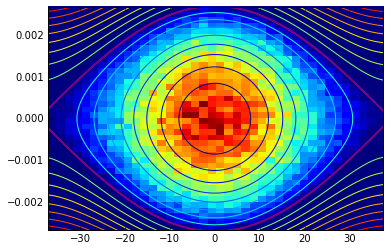

In [6]:
dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
zz = np.linspace(*rfb.interval, num=1000)
Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=100))
H = rfb.hamiltonian(Z, DP)
plt.contour(Z, DP, H, 20)
# plt.scatter(z, dp, alpha=0.6)
plt.hist2d(z, dp, bins=40)
plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)

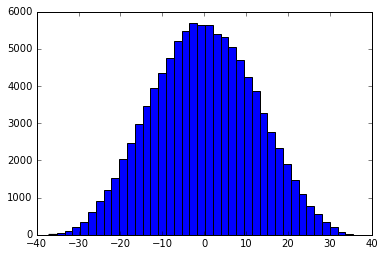

In [7]:
plt.hist(z, bins=40);

# Binomial Distribution

In [8]:
class StationaryBinomial(object):
    def __init__(self, H, Hmax=None, width=1000, Hcut=0):
        self.H = H
        self.H0 = 1
        if not Hmax:
            self.Hmax = H(0, 0)
        else:
            self.Hmax = Hmax
        self.Hcut = Hcut
        self.width = width

    def function(self, z, dp):
        H_hat = self.H(0., 0.).clip(min=0)
        psi = ((1 - self.H(z, dp).clip(min=0)-H_hat)/self.H0)**2 - (1 - H_hat/self.H0)**2
        psi_norm = ((1 - self.Hmax-H_hat)/self.H0)**2 - (1 - H_hat/self.H0)**2
        return psi/psi_norm

In [9]:
rfb_matcher = RFBucketMatcher(rfb, StationaryBinomial, sigma_z=180e-9*0.91*c/4.)

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 17.0916879882m.
... distance to target bunch length: 1.8144e+00
... distance to target bunch length: 1.8146e+00
... distance to target bunch length: -4.7801e-01
... distance to target bunch length: -3.0663e-01
... distance to target bunch length: 7.4928e-01
... distance to target bunch length: -5.6403e-02
... distance to target bunch length: -6.0669e-03
... distance to target bunch length: 1.1685e-04
... distance to target bunch length: -2.2285e-07
... distance to target bunch length: -8.1180e-12
--> Bunch length: 12.2765011551
--> Emittance: 1.1773743277


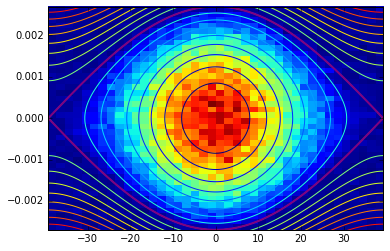

In [10]:
dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
zz = np.linspace(*rfb.interval, num=1000)
Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=100))
H = rfb.hamiltonian(Z, DP)
plt.contour(Z, DP, H, 20)
# plt.scatter(z, dp, alpha=0.6)
plt.hist2d(z, dp, bins=40)
plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)

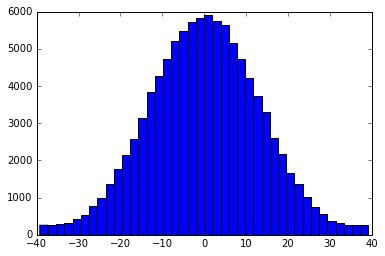

In [11]:
plt.hist(z, bins=40);